In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *
from collections import Counter
import numpy as np
import time

import pandas as pd
import geopandas as gpd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

import itertools as it

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
today = time.strftime("%Y-%m-%d")

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [3]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

la_data = client.open("COVID-data_Louisiana")
contact_data = la_data.worksheet('outbreaks')
contact_df = pd.DataFrame(contact_data.get_all_records(default_blank=np.nan))
contact_df = contact_df.loc[~contact_df['setting'].isin(['College/University',
        'Festival/Fair','Camp','Primary/Secondary School','Vocational School'])].copy()
contact_df = contact_df[['date', 'setting', 'raw_new_clusters', 'raw_new_cases',
                         'raw_total_clusters', 'raw_total_cases']]

contact_df.loc[contact_df['raw_new_cases']<0,'raw_new_cases'] = 0
contact_df.loc[contact_df['raw_new_clusters']<0,'raw_new_clusters'] = 0

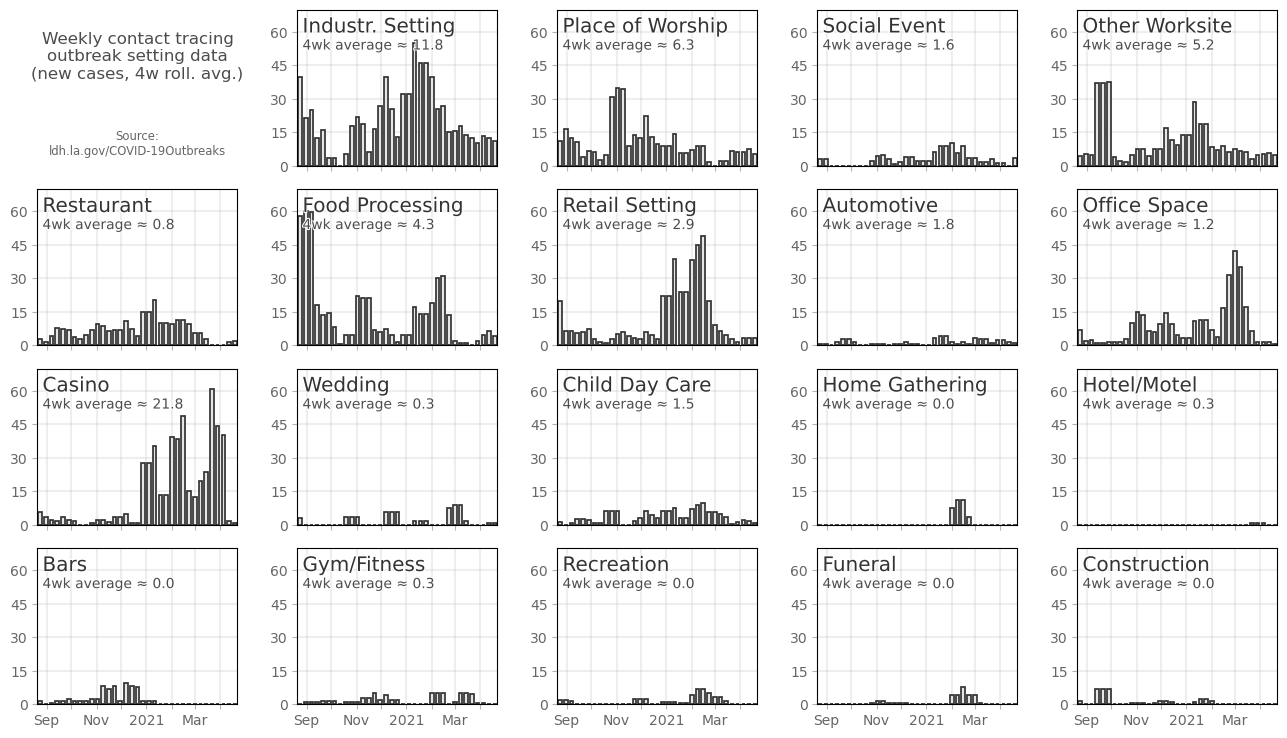

In [4]:
wid = 3
barw = 4.5
w = 3.2; h = 2.3
ncols = 5; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['Automotive', 'Bars',
       'Casino', 'Child Day Care', 'Construction', 'Food Processing', 'Funeral',
       'Gym/Fitness', 'Home Gathering', 'Hotel/Motel', 'Industr. Setting',
       'Office Space', 'Other Worksite', 'Recreation', 'Place of Worship', 'Restaurant',
       'Retail Setting', 'Ship/Boat', 'Social Event', 'Wedding']))

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-09-01','2020-10-01','2020-11-01','2020-12-01',
            '2021-01-01','2021-02-01','2021-03-01','2021-04-01']
dates_ll = ['Sep','','Nov','','2021','','Mar','']

# settings_order = contact_df.loc[contact_df['date']==contact_df['date'].max()\
#                    ].sort_values('raw_new_cases',ascending=False)['setting'].unique()
settings_order = contact_df.loc[contact_df['date'].isin(
                            sorted(contact_df['date'].unique())[-2:])].copy()
settings_order = settings_order.groupby('setting').agg({'raw_new_cases':'sum'}).reset_index()
settings_order = settings_order.sort_values('raw_new_cases',ascending=False)['setting'].unique()

for di, dcurr in enumerate(settings_order[:(len(tups)-1)]):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti = DATE_DF[['date','week']].merge(cti, how='left', on='date')
    cti = cti.loc[(cti['date']>=contact_df['date'].min())&\
                  (cti['date']<=contact_df['date'].max())].copy()
    cti['setting'] = cti['setting'].dropna().values[0]
    cti['raw_new_cases'] = np.nan_to_num(cti['raw_new_cases'])
    cti['raw_new_clusters'] = np.nan_to_num(cti['raw_new_clusters'])
    cti = cti.groupby('week').agg({'raw_new_cases':'sum', 'raw_new_clusters':'sum',
                                   'date':'min'}).reset_index()
    cti = cti.loc[cti['date']>'2020-08-02'].copy()
    cti['raw_new_cases'] = cti['raw_new_cases'].rolling(window=wid).mean().values

    aa.bar([date_dict[i] for i in cti['date']], cti['raw_new_cases'],
           fc='.9', ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    four_wmean = np.nanmean(np.nan_to_num(cti['raw_new_cases'].values)[-4:])
    aa.text(0.025,0.815,'4wk average ≈ %.1f'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict['2020-08-24']-barw/2-1,
                date_dict[cti.dropna()['date'].max()]+barw/2+1)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.25)

    aa.set_ylim(0, 70)


aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases, 4w roll. avg.)',
        ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nldh.la.gov/COVID-19Outbreaks',
        ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/la_outbreak_settings_newcases_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/la_outbreak_settings_newcases_all.pdf',bbox_inches='tight')

plt.show()

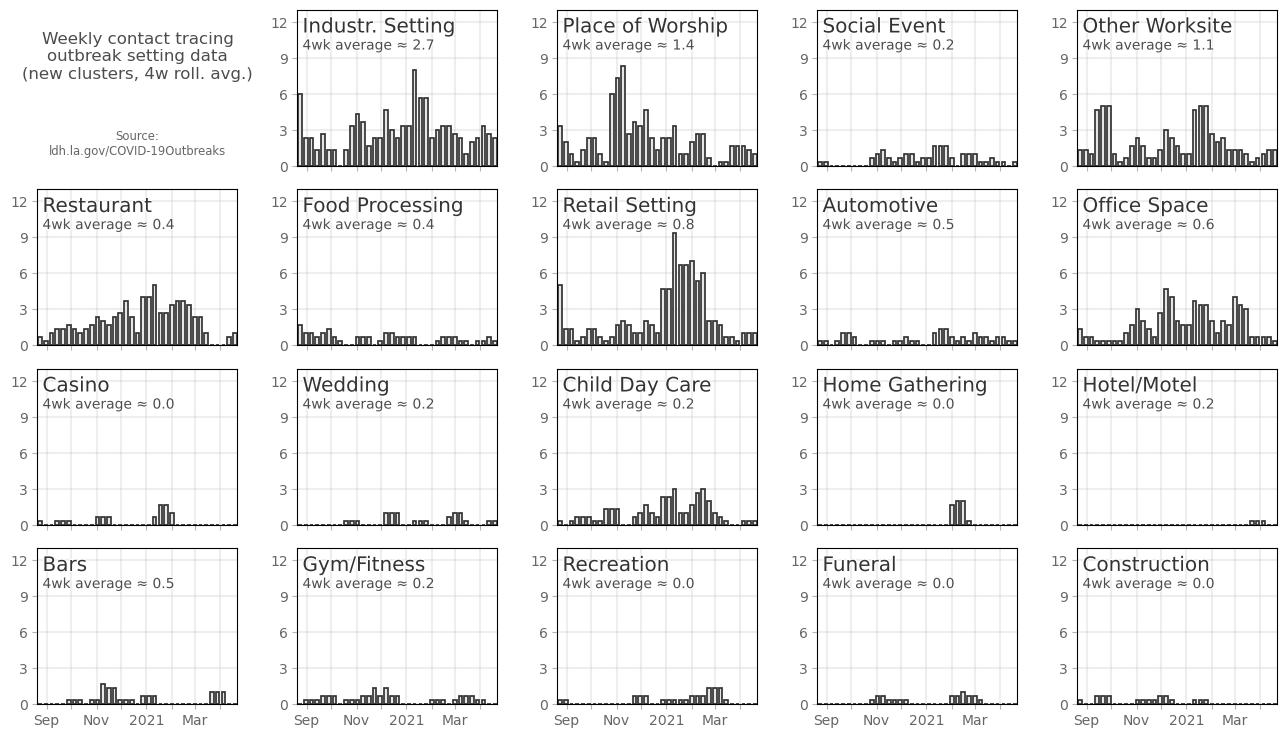

In [5]:
wid = 3
barw = 4.5
w = 3.2; h = 2.3
ncols = 5; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-09-01','2020-10-01','2020-11-01','2020-12-01',
            '2021-01-01','2021-02-01','2021-03-01','2021-04-01']
dates_ll = ['Sep','','Nov','','2021','','Mar','']

for di, dcurr in enumerate(settings_order[:(len(tups)-1)]):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti = DATE_DF[['date','week']].merge(cti, how='left', on='date')
    cti = cti.loc[(cti['date']>=contact_df['date'].min())&\
                  (cti['date']<=contact_df['date'].max())].copy()
    cti['setting'] = cti['setting'].dropna().values[0]
    cti['raw_new_cases'] = np.nan_to_num(cti['raw_new_cases'])
    cti['raw_new_clusters'] = np.nan_to_num(cti['raw_new_clusters'])
    cti = cti.groupby('week').agg({'raw_new_cases':'sum', 'raw_new_clusters':'sum',
                                   'date':'min'}).reset_index()
    cti = cti.loc[cti['date']>'2020-08-02'].copy()
    cti['raw_new_clusters'] = cti['raw_new_clusters'].rolling(window=wid).mean().values

    aa.bar([date_dict[i] for i in cti['date']], cti['raw_new_clusters'],
           fc='.9', ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    four_wmean = np.nanmean(np.nan_to_num(cti['raw_new_clusters'].values)[-4:])
    aa.text(0.025,0.815,'4wk average ≈ %.1f'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict['2020-08-24']-barw/2-1,
                date_dict[cti.dropna()['date'].max()]+barw/2+1)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.25)

    aa.set_ylim(0, 13)


aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new clusters, 4w roll. avg.)',
        ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nldh.la.gov/COVID-19Outbreaks',
        ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/la_outbreak_settings_newclusters_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/la_outbreak_settings_newclusters_all.pdf',bbox_inches='tight')

plt.show()

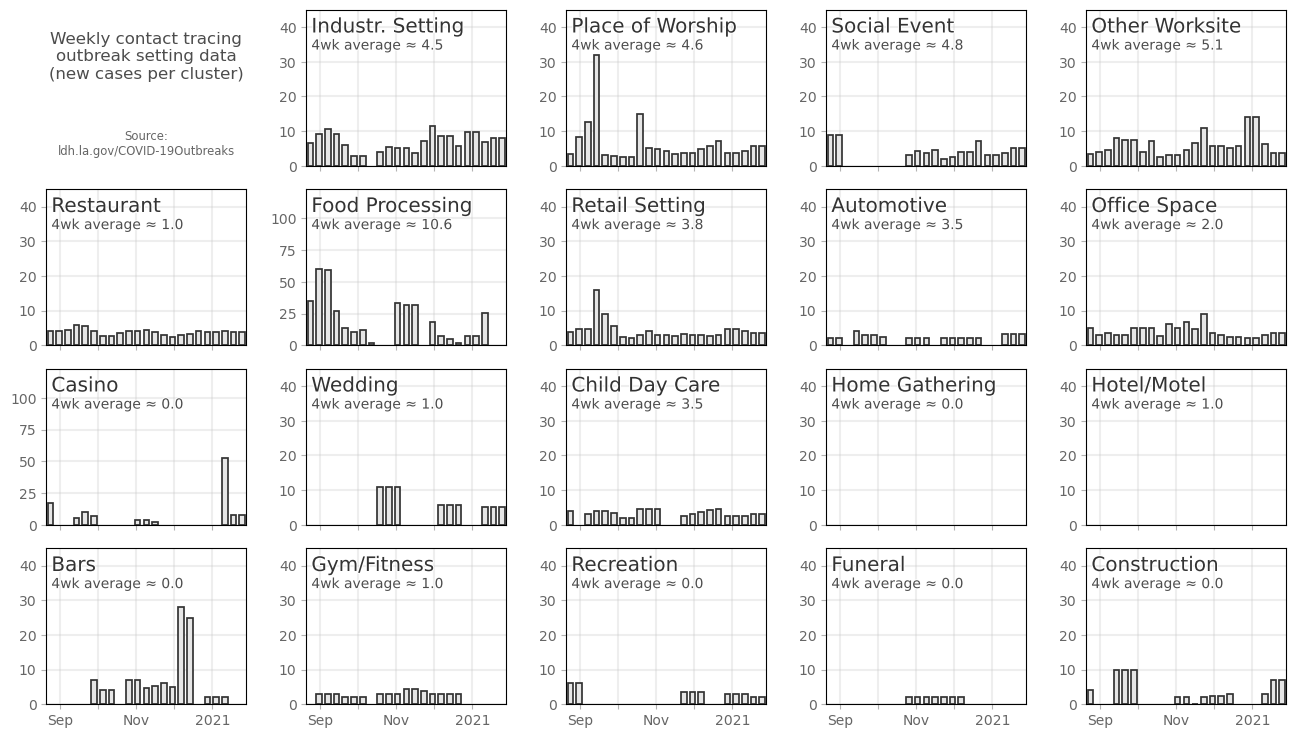

In [6]:
wid = 3
barw = 4.5
w = 3.2; h = 2.3
ncols = 5; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-09-01','2020-10-01','2020-11-01','2020-12-01',
            '2021-01-01','2021-02-01','2021-03-01','2021-04-01']
dates_ll = ['Sep','','Nov','','2021','','Mar','']

for di, dcurr in enumerate(settings_order[:(len(tups)-1)]):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti = DATE_DF[['date','week']].merge(cti, how='left', on='date')
    cti = cti.loc[(cti['date']>=contact_df['date'].min())&\
                  (cti['date']<=contact_df['date'].max())].copy()
    cti['setting'] = cti['setting'].dropna().values[0]
    cti['raw_new_cases'] = np.nan_to_num(cti['raw_new_cases'])
    cti['raw_new_clusters'] = np.nan_to_num(cti['raw_new_clusters'])
    cti = cti.groupby('week').agg({'raw_new_cases':'sum', 'raw_new_clusters':'sum',
                                   'date':'min'}).reset_index()
    cti = cti.loc[cti['date']>'2020-08-02'].copy()
    cti['raw_new_cases'] = cti['raw_new_cases'].rolling(window=wid).mean().values
    cti['raw_new_clusters'] = cti['raw_new_clusters'].rolling(window=wid).mean().values
    cti.loc[cti['raw_new_clusters']==0,'raw_new_clusters'] = np.nan
    cti['raw_new_cases_per']= cti['raw_new_cases'] / cti['raw_new_clusters'].values
#     cti['raw_new_cases_per'] = cti['raw_new_cases_per'].rolling(window=2).mean().values
    aa.bar([date_dict[i] for i in cti['date']], cti['raw_new_cases_per'],
           fc='.9', ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    four_wmean = np.nanmean(np.nan_to_num(cti['raw_new_cases_per'].values)[-4:])
    aa.text(0.025,0.815,'4wk average ≈ %.1f'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict['2020-08-24']-barw/2-1,
                date_dict[cti.dropna()['date'].max()]+barw/2+1)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.25)

    if labs[dcurr] in ['Casino','Food Processing']:
        aa.set_ylim(0, 123)
    else:
        aa.set_ylim(0, 45)
    


aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases per cluster)',
        ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nldh.la.gov/COVID-19Outbreaks',
        ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/la_outbreak_settings_newcases_per_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/la_outbreak_settings_newcases_per_all.pdf',bbox_inches='tight')

plt.show()